In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pm

#### Série do IPCA-15

In [2]:
df = pd.read_excel('ipcaselic.xls', index_col = 'Data')
df.head()

,Selic,IPCA15
Data,,
2000-05-01,18.51,0.09
2000-06-01,18.04,0.08
2000-07-01,16.85,0.78
2000-08-01,16.52,1.99
2000-09-01,16.56,0.45


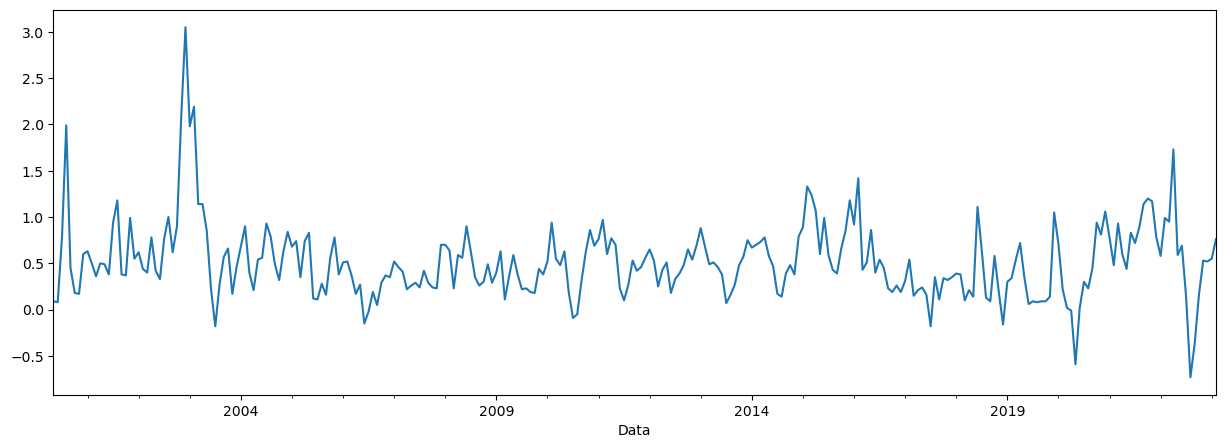

In [3]:
df['IPCA15'].plot(figsize = (15,5));

Claramente é estacionária, mas vamos conferir!

In [4]:
adfuller(df['IPCA15'])

(-7.753209268159394,
 9.893290390048137e-12,
 0,
 273,
 {'1%': -3.45453261164607,
  '5%': -2.8721859575020017,
  '10%': -2.572442854861866},
 110.46605473351434)

In [5]:
corte = int(len(df)*0.95)
print(corte)
train = df.iloc[:corte]
test = df.iloc[corte:]

260


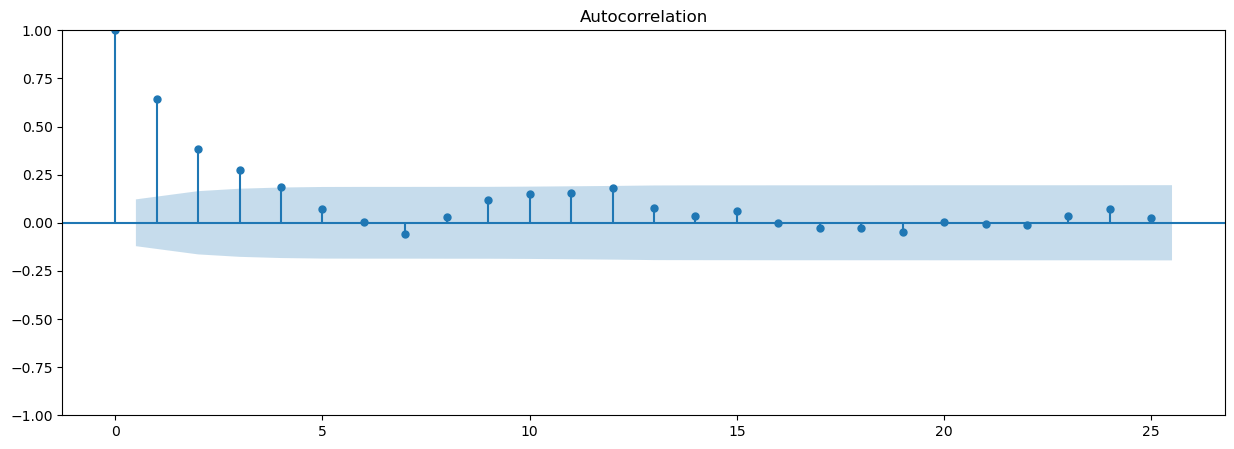

In [6]:
fig, ax = plt.subplots(figsize = (15,5))
plot_acf(np.array(train['IPCA15']), ax=ax);

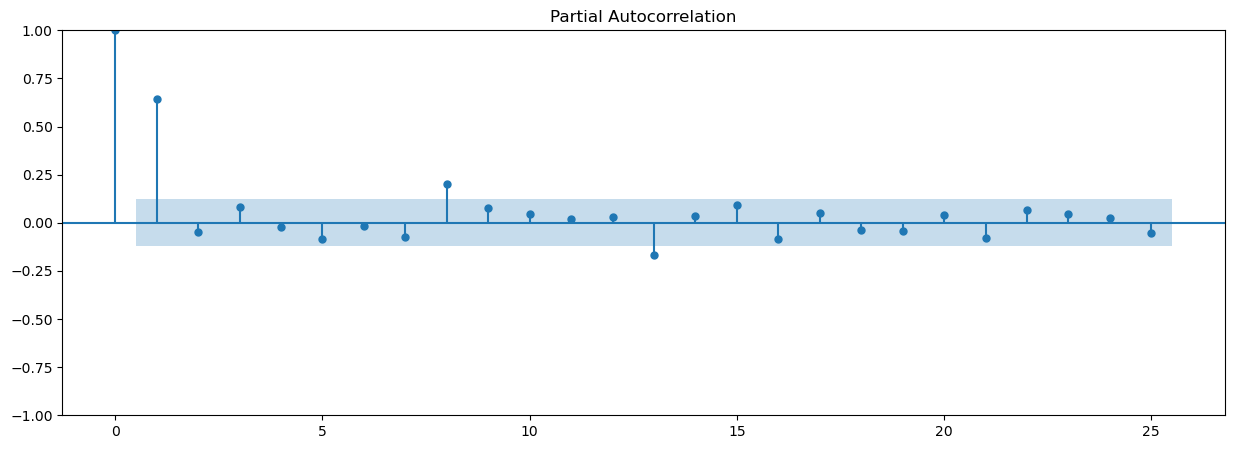

In [7]:
fig, ax = plt.subplots(figsize = (15,5))
plot_pacf(np.array(train['IPCA15']), ax=ax);

##### Modelo usando o ARIMA do STATSMODELS. Não consideramos sazonalidade ainda!!

In [8]:
IPCA_Model = ARIMA(train['IPCA15'], order=(1,0,3), trend='c', freq='MS');
IPCA_predictor = IPCA_Model.fit();
IPCA_predictor.summary()

C:\Users\hugos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 IPCA15   No. Observations:                  260
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 -58.122
Date:                Fri, 16 Jun 2023   AIC                            128.244
Time:                        09:07:44   BIC                            149.608
Sample:                    05-01-2000   HQIC                           136.833
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5131      0.061      8.368      0.000       0.393       0.633
ar.L1          0.6536      0.158      4.135      0.000       0.344       0.963
ma.L1          0.0210      0.164      0.127      0.899      -0.301       0.343
ma.L2         -0.0721      0.123     -0.587      0.557      -0.313       0.168
ma.L3          0.0333      0.084      0.395      0.693      -0.132       0.198
sigma2         0.0914      0.005     17.417      0.000       0.081       0.102
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               242.14
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             1.02
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
IPCA_model = IPCA_predictor.predict(start = 0, end = len(train)-1, typ='levels')

In [10]:
IPCA_forecast = IPCA_predictor.get_forecast('2023-02-01').summary_frame(alpha=0.10)

In [11]:
# Calculando o RMSE
rmse_train = np.sqrt(mean_squared_error(train['IPCA15'],IPCA_model))
rmse_test = np.sqrt(mean_squared_error(test['IPCA15'], IPCA_forecast['mean']))

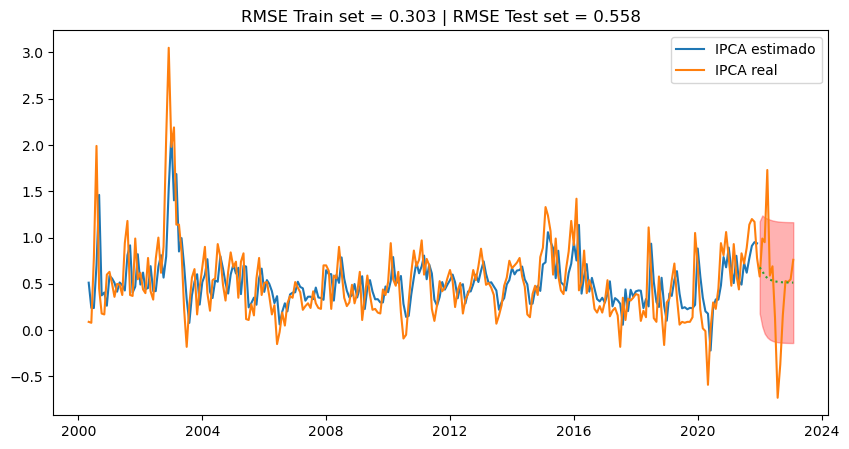

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train.index, IPCA_model, label = 'IPCA estimado')
ax.plot(df.index, df.IPCA15, label = 'IPCA real')
ax.fill_between(IPCA_forecast.index, IPCA_forecast['mean_ci_lower'],
                 IPCA_forecast['mean_ci_upper'], color='red', alpha=0.3)

ax.plot(test.index, IPCA_forecast['mean'],linestyle = 'dotted')

plt.title('RMSE Train set = ' + str(round(rmse_train,3) ) +' | '+ 'RMSE Test set = ' + str(round(rmse_test,3) ))
ax.legend();

### O que são critérios de informação e para que os usamos?

São medidas estatísticas usadas para seleção de modelos. As mais usadas são o Akaike information criterion (AIC),  Bayesian information criterion (BIC) e Hannan–Quinn information criterion (HQIC).

#### Como funcionam?

São baseados na ideia de que um bom modelo deve se ajustar bem aos dados, mas também deve ser parcimonioso, ou seja, não deve ser excessivamente complexo.

A fórmula geral do AIC é a seguinte: $$AIC = -2\log{L} + 2k$$

Onde:

* $\log(L)$ é o logaritmo da função de verossimilhança do modelo, que mede a adequação do modelo aos dados observados;
* $k$ é o número de parâmetros no modelo.

O AIC é calculado como a soma de duas partes:

A primeira parte, $-2\log(L)$, penaliza a falta de ajuste do modelo aos dados. Quanto menor o valor de $\log(L)$, pior o ajuste do modelo.
A segunda parte, $2 k$, penaliza a complexidade do modelo. Quanto maior o número de parâmetros ($k$), maior a penalização.

**Ao escolher o modelo com o menor AIC, está sendo buscado um equilíbrio entre a capacidade de explicação dos dados e a simplicidade do modelo. Isso ajuda a evitar o overfitting (ajuste excessivo aos dados de treinamento) e a selecionar modelos mais robustos e generalizáveis.**

A fórmula geral do BIC é a seguinte: $$BIC = -2 \log(L) + k \log(n)$$

Onde:

* $\log(L)$ é o logaritmo da função de verossimilhança do modelo;
* $k$ é o número de parâmetros no modelo;
* $n$ é o tamanho da amostra (número de observações).

Assim como o AIC, o BIC também é uma combinação de duas partes:

A primeira parte, $-2 \log(L)$, mede a qualidade do ajuste do modelo aos dados.
A segunda parte, $k \log(n)$, penaliza a complexidade do modelo, levando em consideração o número de parâmetros e o tamanho da amostra.

##### Vamos usar o Auto_Arima para identificar a melhor ordem do modelo. Rodamos agora dentro do próprio Auto_Arima!!

In [13]:
model = pm.auto_arima(train['IPCA15'], trace=True, supress_warnings = True, seasonal = False,
                      stepwise = False, max_p = 12, max_q = 2, max_order=14)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=515.489, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=327.475, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=255.118, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=156.173, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=155.308, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=145.528, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=156.518, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=160.172, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=149.479, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=150.660, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=152

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  260
Model:              SARIMAX(12, 0, 2)   Log Likelihood                 -48.417
Date:                Fri, 16 Jun 2023   AIC                            126.833
Time:                        09:18:27   BIC                            180.243
Sample:                    05-01-2000   HQIC                           148.305
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4248      0.088     -4.812      0.000      -0.598      -0.252
ar.L2         -0.0869      0.072     -1.205      0.228      -0.228       0.054
ar.L3          0.6381      0.065      9.746      0.000       0.510       0.766
ar.L4          0.1544      0.067      2.314      0.021       0.024       0.285
ar.L5          0.1280      0.076      1.694      0.090      -0.020       0.276
ar.L6          0.0102      0.068      0.151      0.880      -0.123       0.144
ar.L7         -0.2083      0.075     -2.765      0.006      -0.356      -0.061
ar.L8          0.0028      0.099      0.029      0.977      -0.191       0.197
ar.L9          0.1198      0.097      1.233      0.217      -0.071       0.310
ar.L10         0.3344      0.069      4.873      0.000       0.200       0.469
ar.L11         0.1045      0.077      1.352      0.176      -0.047       0.256
ar.L12         0.2152      0.078      2.748      0.006       0.062       0.369
ma.L1          1.1754      0.078     14.978      0.000       1.022       1.329
ma.L2          0.8694      0.070     12.396      0.000       0.732       1.007
sigma2         0.0836      0.005     17.027      0.000       0.074       0.093
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               263.56
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.87
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

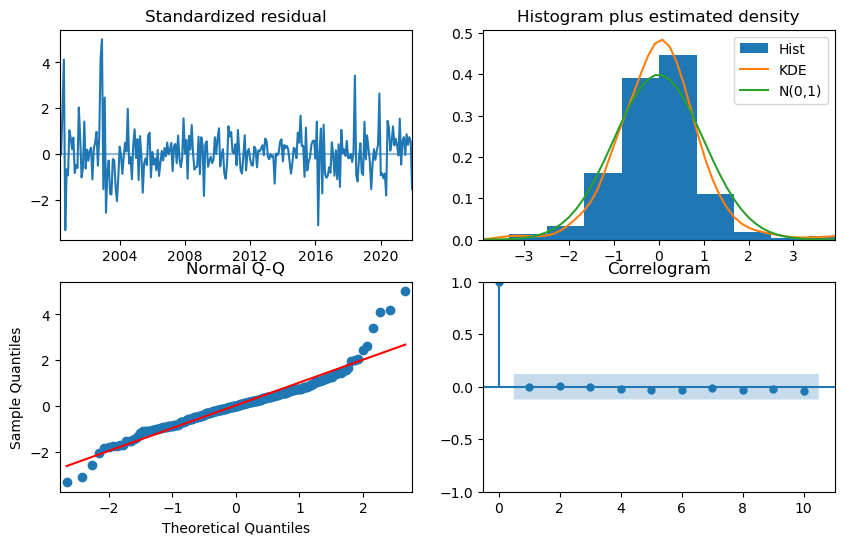

In [15]:
model.plot_diagnostics(figsize=(10,6));

In [16]:
test_pred, confint = model.predict(len(test), return_conf_int = True)

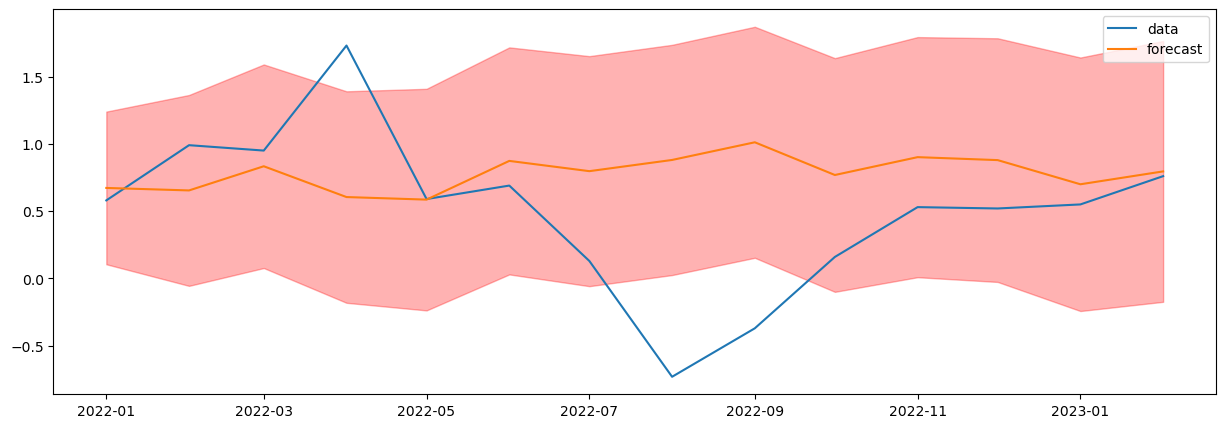

In [17]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(test.index, test['IPCA15'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)
ax.legend();

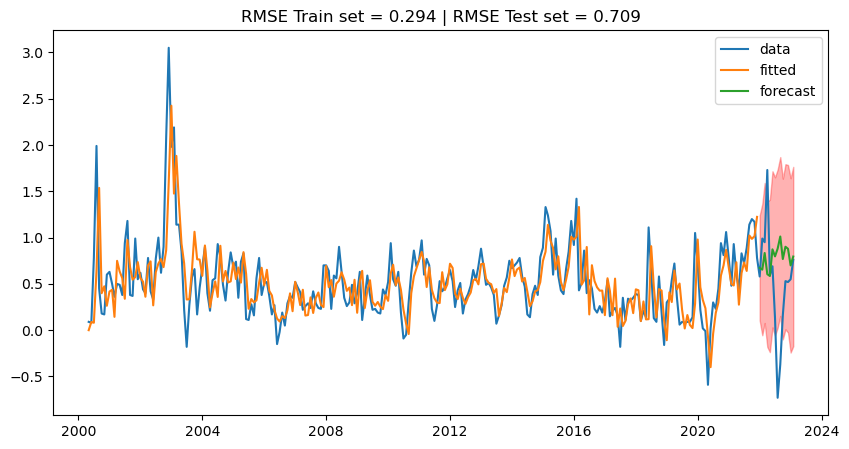

In [18]:
train_pred = model.predict_in_sample(start = 0, end = -1)


# Calculando o RMSE
rmse_train = np.sqrt(mean_squared_error(train['IPCA15'],train_pred))
rmse_test = np.sqrt(mean_squared_error(test['IPCA15'], test_pred))


fig, ax = plt.subplots(figsize = (10,5))
ax.plot(df.index, df['IPCA15'], label='data')
ax.plot(train.index, train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)

plt.title('RMSE Train set = ' + str(round(rmse_train,3) ) +' | '+ 'RMSE Test set = ' + str(round(rmse_test,3) ))

ax.legend();

##### Agora vamos usar o Auto_Arima, porém considerando presença de sazonalidade!!

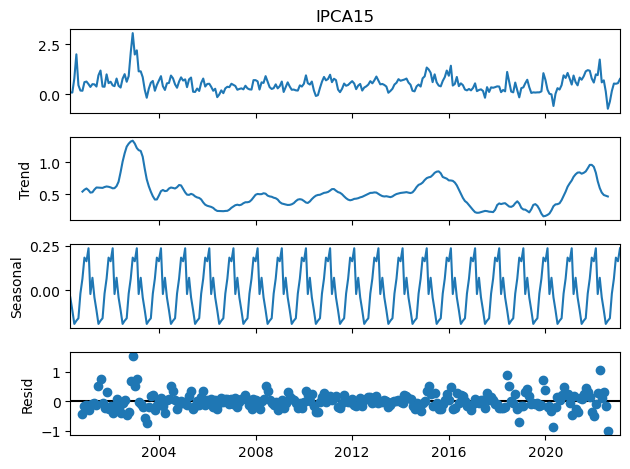

In [19]:
IPCA_decomp =seasonal_decompose(df['IPCA15'])
IPCA_decomp.plot();

In [20]:
model_1 = pm.auto_arima(train['IPCA15'], trace=True, supress_warnings = True, seasonal = True,
                      stepwise = False, max_p = 12, max_q = 2, max_order=15, m=12)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=261.406, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=255.268, Time=0.17 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=256.111, Time=0.30 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=254.321, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=255.575, Time=0.43 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=255.734, Time=0.46 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=256.784, Time=0.92 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=258.568, Time=0.96 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=156.373, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=149.874, Time=0.18 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=149.490, Time=0.39 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=148.367, Time=0.20 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=146.923, Time=0.52 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=147.836, Time=1.41 sec
 ARIMA(0,0,1)(

 ARIMA(4,0,1)(2,0,2)[12] intercept   : AIC=121.747, Time=2.10 sec
 ARIMA(4,0,2)(0,0,0)[12] intercept   : AIC=119.638, Time=0.60 sec
 ARIMA(4,0,2)(0,0,1)[12] intercept   : AIC=119.979, Time=1.00 sec
 ARIMA(4,0,2)(0,0,2)[12] intercept   : AIC=120.150, Time=2.05 sec
 ARIMA(4,0,2)(1,0,0)[12] intercept   : AIC=119.094, Time=0.94 sec
 ARIMA(4,0,2)(1,0,1)[12] intercept   : AIC=118.805, Time=1.02 sec
 ARIMA(4,0,2)(1,0,2)[12] intercept   : AIC=121.590, Time=2.11 sec
 ARIMA(4,0,2)(2,0,0)[12] intercept   : AIC=121.005, Time=2.13 sec
 ARIMA(4,0,2)(2,0,1)[12] intercept   : AIC=121.568, Time=1.96 sec
 ARIMA(4,0,2)(2,0,2)[12] intercept   : AIC=123.558, Time=2.15 sec
 ARIMA(5,0,0)(0,0,0)[12] intercept   : AIC=128.072, Time=0.21 sec
 ARIMA(5,0,0)(0,0,1)[12] intercept   : AIC=122.280, Time=0.32 sec
 ARIMA(5,0,0)(0,0,2)[12] intercept   : AIC=122.028, Time=0.72 sec
 ARIMA(5,0,0)(1,0,0)[12] intercept   : AIC=120.809, Time=0.60 sec
 ARIMA(5,0,0)(1,0,1)[12] intercept   : AIC=117.682, Time=1.12 sec
 ARIMA(5,0

 ARIMA(9,0,0)(2,0,1)[12] intercept   : AIC=119.104, Time=4.54 sec
 ARIMA(9,0,0)(2,0,2)[12] intercept   : AIC=121.262, Time=6.52 sec
 ARIMA(9,0,1)(0,0,0)[12] intercept   : AIC=122.132, Time=0.81 sec
 ARIMA(9,0,1)(0,0,1)[12] intercept   : AIC=120.865, Time=0.92 sec
 ARIMA(9,0,1)(0,0,2)[12] intercept   : AIC=122.156, Time=2.76 sec
 ARIMA(9,0,1)(1,0,0)[12] intercept   : AIC=120.426, Time=1.55 sec
 ARIMA(9,0,1)(1,0,1)[12] intercept   : AIC=119.103, Time=1.99 sec
 ARIMA(9,0,1)(1,0,2)[12] intercept   : AIC=120.985, Time=2.64 sec
 ARIMA(9,0,1)(2,0,0)[12] intercept   : AIC=121.804, Time=5.27 sec
 ARIMA(9,0,1)(2,0,1)[12] intercept   : AIC=121.010, Time=5.77 sec
 ARIMA(9,0,1)(2,0,2)[12] intercept   : AIC=123.076, Time=5.63 sec
 ARIMA(9,0,2)(0,0,0)[12] intercept   : AIC=121.843, Time=0.94 sec
 ARIMA(9,0,2)(0,0,1)[12] intercept   : AIC=121.110, Time=1.90 sec
 ARIMA(9,0,2)(0,0,2)[12] intercept   : AIC=122.697, Time=3.11 sec
 ARIMA(9,0,2)(1,0,0)[12] intercept   : AIC=122.017, Time=2.10 sec
 ARIMA(9,0

##### Lembrando a equação geral do modelo ARIMA:

Façamos $y^{[d]}_t = \Delta y^{[d]}_t = y^{[d-1]}_t - y^{[d-1]}_{t-1}$ onde $d$ é a ordem da diferenciação. O modelo ARIMA$(p,d,q)$ é $$y^{[d]}_t = \alpha_0 + \sum_{i=1}^{p}\alpha_i y^{[d]}_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \epsilon_t.$$



##### Adicionando sazonalidade ao modelo ARIMA teremos o modelo SARIMA:

Agora considere que a série $\{y_t\}_{t=1}^{T}$ tenha sazonalidade com período $s$. O modelo SARIMA$(p,d,q)(P,D,Q,s)$ considera termos AR(P) e MA(Q) cuja diferenciação é realizada considerando o período da sazonalidade $s$. Agora, $y^{[D]}_t = \Delta y^{[D]}_t = y^{[D-1]}_t - y^{[D-1]}_{t-s}$,  O modelo é: $$y^{[d,D]}_t = \alpha_0 + \sum_{i=1}^{p}\alpha_i y^{[d,D]}_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \sum_{k=1}^{P}\beta_k y^{[d,D]}_{t-sk} + \sum_{l=1}^{Q} \phi_l \epsilon_{t-sl} + \epsilon_t.$$



In [21]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  260
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -51.415
Date:                              Fri, 16 Jun 2023   AIC                            112.829
Time:                                      09:35:32   BIC                            130.633
Sample:                                  05-01-2000   HQIC                           119.986
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0230      0.017      1.372      0.170      -0.010       0.056
ar.L1          0.6562      0.031     21.236      0.000       0.596       0.717
ar.S.L12       0.8728      0.089      9.815      0.000       0.699       1.047
ma.S.L12      -0.7305      0.124     -5.913      0.000      -0.973      -0.488
sigma2         0.0861      0.005     17.002      0.000       0.076       0.096
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               277.00
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             1.05
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

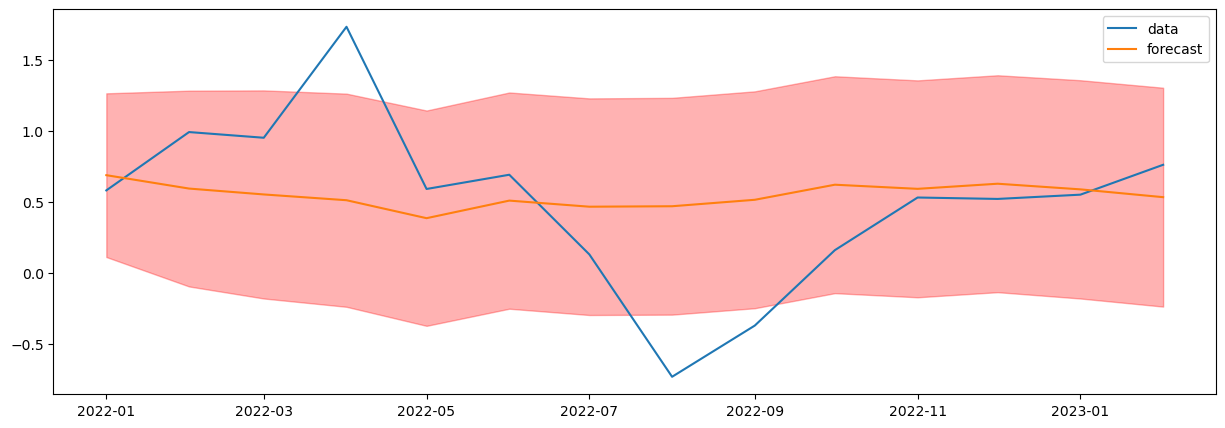

In [22]:
test_pred, confint = model_1.predict(len(test), return_conf_int = True)

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(test.index, test['IPCA15'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)
ax.legend();

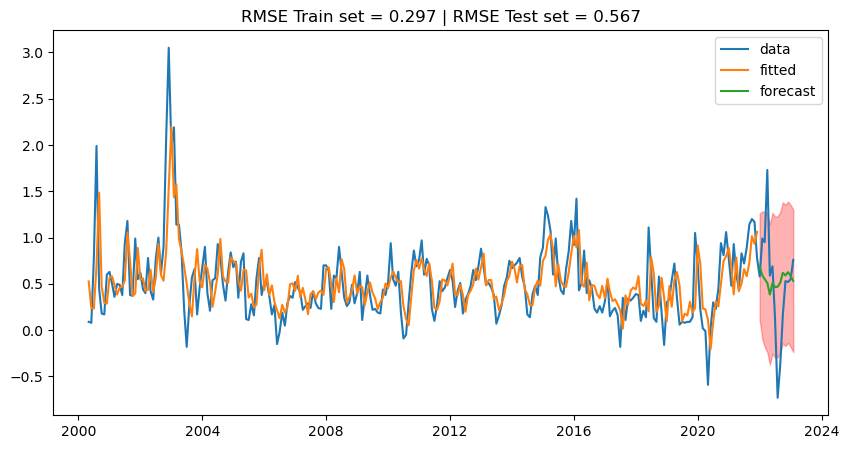

In [23]:
train_pred = model_1.predict_in_sample(start = 0, end = -1)


# Calculando o RMSE
rmse_train = np.sqrt(mean_squared_error(train['IPCA15'],train_pred))
rmse_test = np.sqrt(mean_squared_error(test['IPCA15'], test_pred))


fig, ax = plt.subplots(figsize = (10,5))
ax.plot(df.index, df['IPCA15'], label='data')
ax.plot(train.index, train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)

plt.title('RMSE Train set = ' + str(round(rmse_train,3) ) +' | '+ 'RMSE Test set = ' + str(round(rmse_test,3) ))

ax.legend();

In [24]:
df = pd.read_csv('airline_passengers.csv', index_col = 'Month', parse_dates = True)

In [25]:
df['DiffPassengers'] = df['Passengers'].diff()

In [26]:
adfuller(df['DiffPassengers'].dropna())

(-2.829266824169998,
 0.054213290283825676,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

In [27]:
from scipy.stats import boxcox

In [28]:
df['BoxCox'], lamb = boxcox(df.Passengers)
lamb

0.14802265137037945

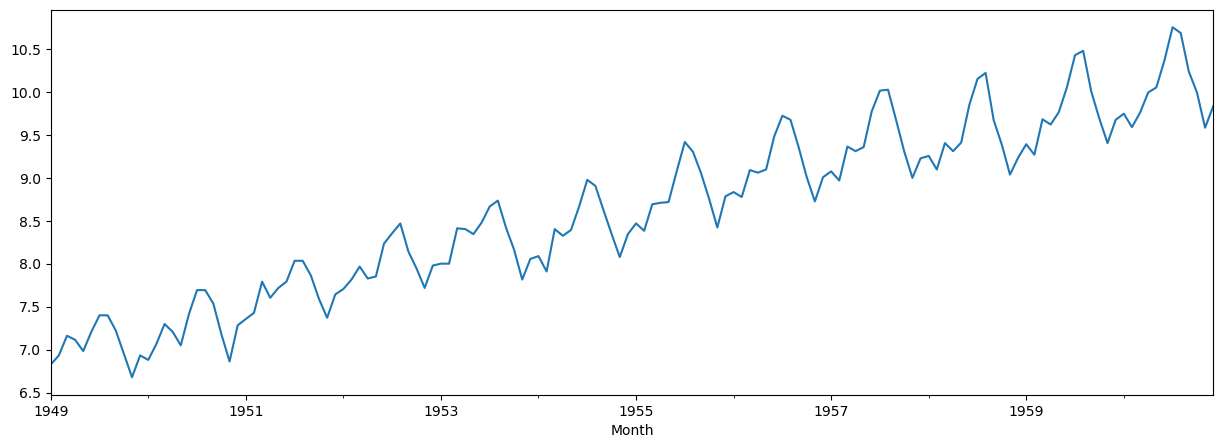

In [29]:
df['BoxCox'].plot(figsize=(15,5));

In [30]:
df['DiffBoxCox'] = df['BoxCox'].diff()

In [31]:
adfuller(df['DiffBoxCox'].dropna())

(-2.8717075283173914,
 0.04873833392661849,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 -234.74315733709795)

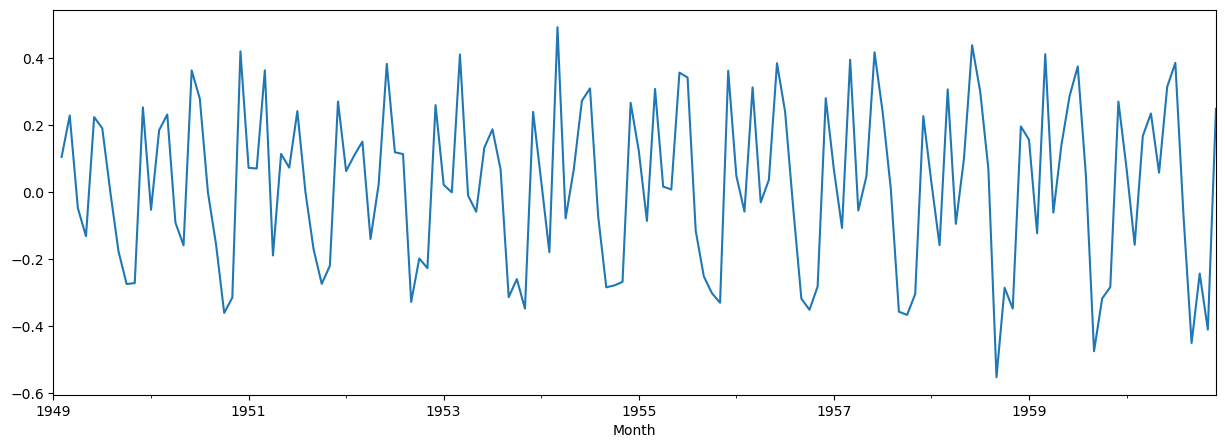

In [32]:
df['DiffBoxCox'].plot(figsize=(15,5));

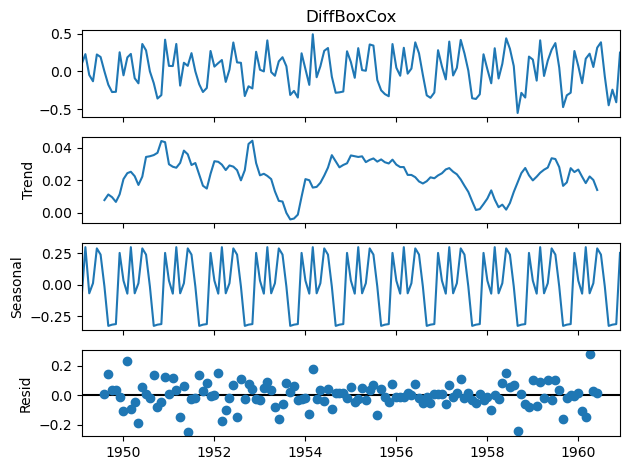

In [33]:
Passengers_decomp =seasonal_decompose(df['DiffBoxCox'].dropna())
Passengers_decomp.plot();

In [34]:
corte = int(len(df)*0.95)
print(corte)
train = df.iloc[:corte]
test = df.iloc[corte:]

136


In [35]:
model_1 = pm.auto_arima(train['DiffBoxCox'].dropna(), trace=True, supress_warnings = True, seasonal = True,
                      stepwise = False, max_p = 13, max_q = 2, max_order=18, m=12)

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-205.851, Time=0.08 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-231.532, Time=0.35 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=-229.532, Time=1.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-224.442, Time=0.16 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-229.532, Time=0.37 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=-228.842, Time=0.96 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-227.282, Time=0.39 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-227.710, Time=0.81 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-219.030, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-244.280, Time=0.37 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-242.920, Time=1.03 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-241.384, Time=0.32 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-242.855, Time=0.47 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-243.621, Time=1.17 sec


 ARIMA(4,0,1)(2,1,1)[12] intercept   : AIC=-237.064, Time=1.87 sec
 ARIMA(4,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(4,0,2)(0,1,0)[12] intercept   : AIC=-219.605, Time=0.60 sec
 ARIMA(4,0,2)(0,1,1)[12] intercept   : AIC=-239.173, Time=1.05 sec
 ARIMA(4,0,2)(0,1,2)[12] intercept   : AIC=-236.883, Time=1.89 sec
 ARIMA(4,0,2)(1,1,0)[12] intercept   : AIC=-234.998, Time=1.04 sec
 ARIMA(4,0,2)(1,1,1)[12] intercept   : AIC=-237.010, Time=1.13 sec
 ARIMA(4,0,2)(1,1,2)[12] intercept   : AIC=-235.418, Time=2.13 sec
 ARIMA(4,0,2)(2,1,0)[12] intercept   : AIC=-235.589, Time=1.85 sec
 ARIMA(4,0,2)(2,1,1)[12] intercept   : AIC=-235.098, Time=1.92 sec
 ARIMA(4,0,2)(2,1,2)[12] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(5,0,0)(0,1,0)[12] intercept   : AIC=-218.002, Time=0.25 sec
 ARIMA(5,0,0)(0,1,1)[12] intercept   : AIC=-240.849, Time=0.72 sec
 ARIMA(5,0,0)(0,1,2)[12] intercept   : AIC=-239.071, Time=1.62 sec
 ARIMA(5,0,0)(1,1,0)[12] intercept   : AIC=-237.093, Time=0.88 sec
 ARIM

 ARIMA(9,0,0)(1,1,2)[12] intercept   : AIC=-234.522, Time=2.25 sec
 ARIMA(9,0,0)(2,1,0)[12] intercept   : AIC=-234.942, Time=4.19 sec
 ARIMA(9,0,0)(2,1,1)[12] intercept   : AIC=-234.144, Time=4.10 sec
 ARIMA(9,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=4.85 sec
 ARIMA(9,0,1)(0,1,0)[12] intercept   : AIC=-215.485, Time=1.02 sec
 ARIMA(9,0,1)(0,1,1)[12] intercept   : AIC=-235.557, Time=1.36 sec
 ARIMA(9,0,1)(0,1,2)[12] intercept   : AIC=-225.407, Time=2.30 sec
 ARIMA(9,0,1)(1,1,0)[12] intercept   : AIC=-232.639, Time=1.73 sec
 ARIMA(9,0,1)(1,1,1)[12] intercept   : AIC=-233.924, Time=1.94 sec
 ARIMA(9,0,1)(1,1,2)[12] intercept   : AIC=-232.301, Time=2.48 sec
 ARIMA(9,0,1)(2,1,0)[12] intercept   : AIC=-232.879, Time=4.52 sec
 ARIMA(9,0,1)(2,1,1)[12] intercept   : AIC=-231.771, Time=5.40 sec
 ARIMA(9,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=4.81 sec
 ARIMA(9,0,2)(0,1,0)[12] intercept   : AIC=-217.267, Time=0.96 sec
 ARIMA(9,0,2)(0,1,1)[12] intercept   : AIC=-233.522, Time=1.38 sec
 ARIM

In [36]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  135
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 126.140
Date:                            Fri, 16 Jun 2023   AIC                           -244.280
Time:                                    09:51:51   BIC                           -233.031
Sample:                                02-01-1949   HQIC                          -239.711
                                     - 04-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.003      0.120      0.905      -0.005       0.006
ma.L1         -0.3766      0.074     -5.112      0.000      -0.521      -0.232
ma.S.L12      -0.4986      0.102     -4.892      0.000      -0.698      -0.299
sigma2         0.0073      0.001      8.350      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.94   Prob(JB):                         0.73
Heteroskedasticity (H):               0.71   Skew:                             0.07
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

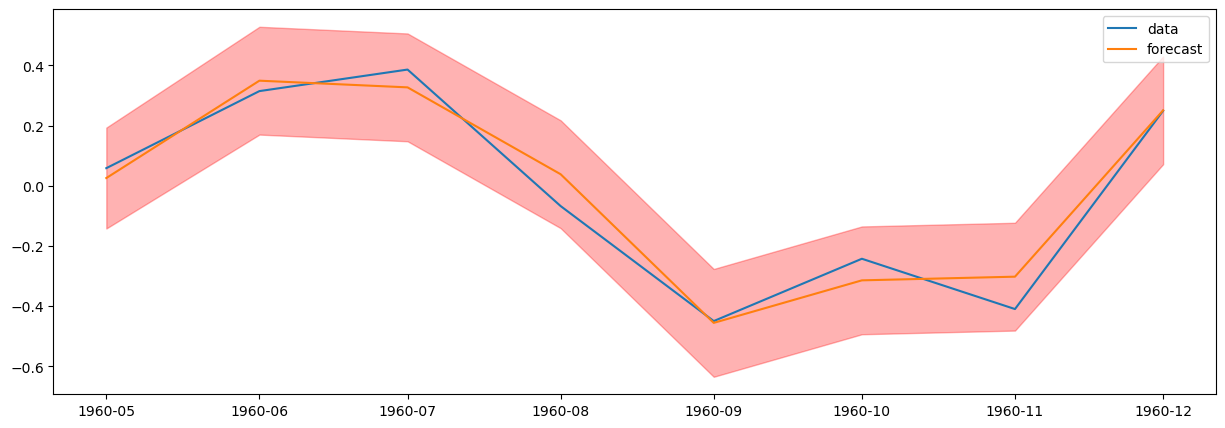

In [37]:
test_pred, confint = model_1.predict(len(test), return_conf_int = True)

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(test.index, test['DiffBoxCox'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)
ax.legend();

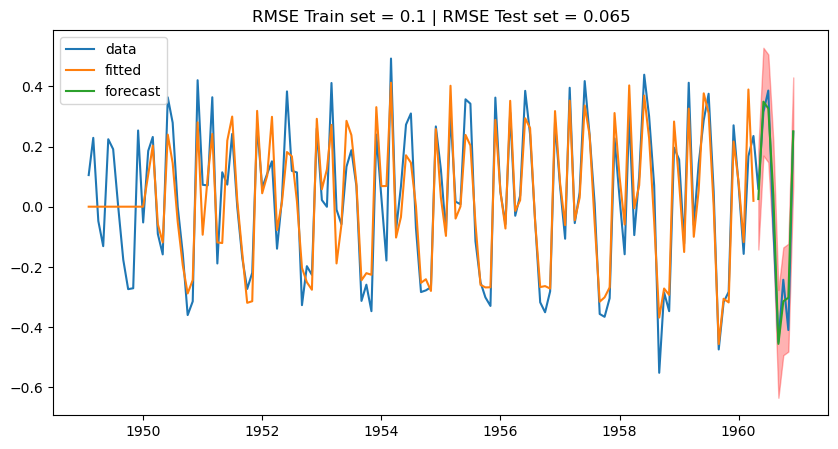

In [38]:
train_pred = model_1.predict_in_sample(start = 0, end = -1)


# Calculando o RMSE
rmse_train = np.sqrt(mean_squared_error(train['DiffBoxCox'].dropna(),train_pred))
rmse_test = np.sqrt(mean_squared_error(test['DiffBoxCox'], test_pred))


fig, ax = plt.subplots(figsize = (10,5))
ax.plot(df.index, df['DiffBoxCox'], label='data')
ax.plot(train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)

plt.title('RMSE Train set = ' + str(round(rmse_train,3) ) +' | '+ 'RMSE Test set = ' + str(round(rmse_test,3) ))

ax.legend();

In [39]:
df = pd.read_csv('URA.csv', index_col = 'Date', parse_dates =True)
ura = df[['Close']]
ura.index.freq = 'w-Mon'

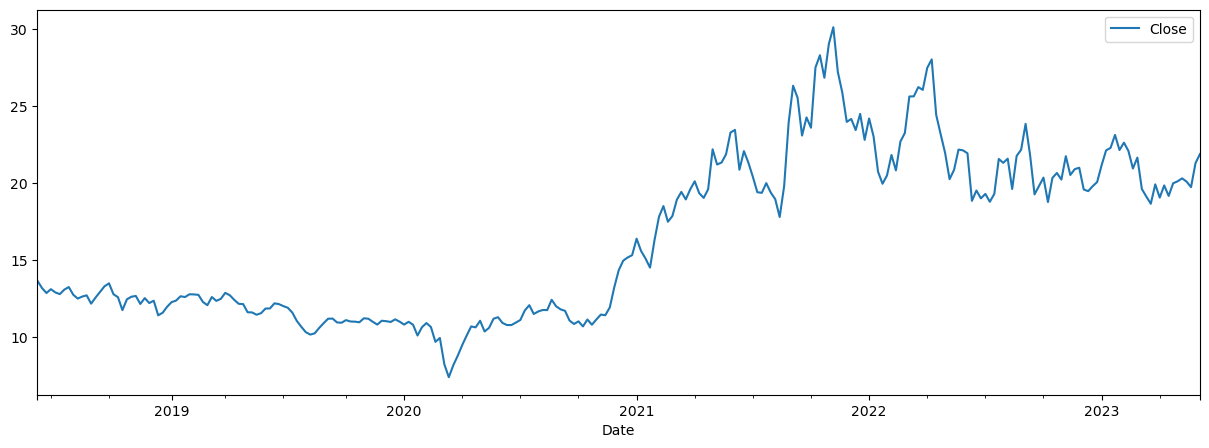

In [40]:
ura.plot(figsize = (15,5));

In [41]:
adfuller(ura)

(-1.350573571722572,
 0.6057292652333908,
 0,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 699.2516504479324)

In [42]:
ura['LogDiff'] = np.log(ura['Close']).diff()

C:\Users\hugos\AppData\Local\Temp\ipykernel_5116\2432585651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ura['LogDiff'] = np.log(ura['Close']).diff()


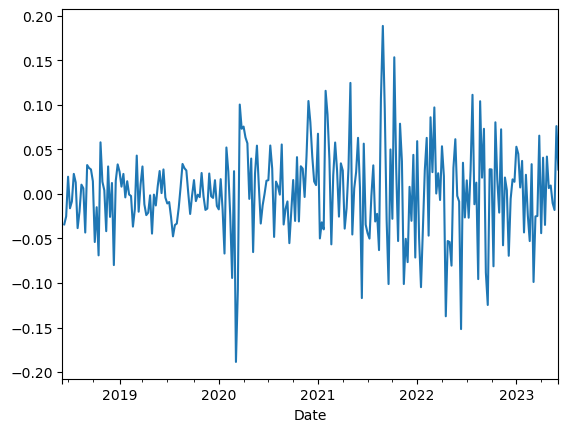

In [43]:
ura['LogDiff'].plot();


In [44]:
adfuller(ura['LogDiff'].dropna())

(-15.114783398816776,
 7.606335707265372e-28,
 0,
 259,
 {'1%': -3.4558530692911504,
  '5%': -2.872764881778665,
  '10%': -2.572751643088207},
 -743.7963792416895)

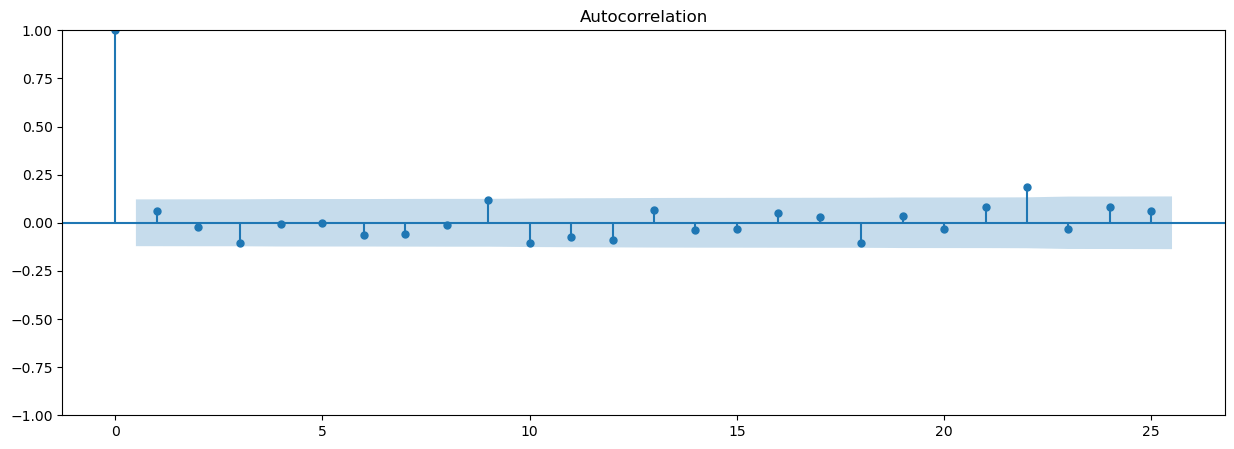

In [45]:
fig, ax = plt.subplots(figsize = (15,5))
plot_acf(ura['LogDiff'].dropna(), ax=ax);

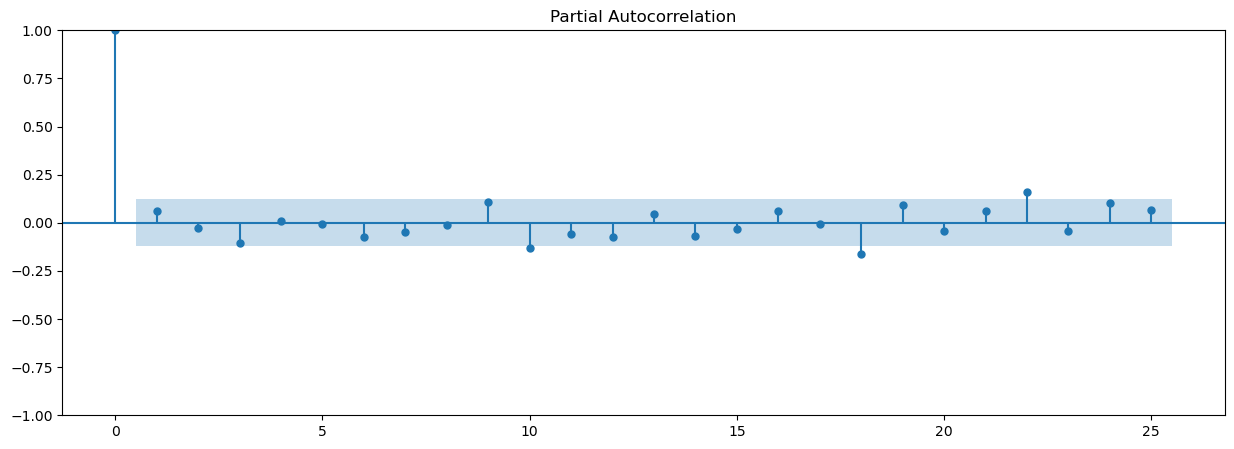

In [46]:
fig, ax = plt.subplots(figsize = (15,5))
plot_pacf(ura['LogDiff'].dropna(), ax=ax);

In [ ]:
ura['DiffPrices'] = ura['Close'].diff()

In [ ]:
ura.DiffPrices.plot(figsize=(15,5));

In [ ]:
adfuller(ura['DiffPrices'].dropna())

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
plot_acf(ura['DiffPrices'].dropna(), ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
plot_pacf(ura['DiffPrices'].dropna(), ax=ax);

In [ ]:
ura.describe()

In [ ]:
ura.dropna(inplace=True)

In [ ]:
N_test = 12
train = ura.iloc[:-N_test]
test = ura.iloc[-N_test:]

In [ ]:
Decomp_results = seasonal_decompose(ura['DiffPrices'])
Decomp_results.plot();

In [ ]:
model = pm.auto_arima(train['DiffPrices'], trace=True, supress_warnings = True, seasonal = True,
                      m=52, stepwise = False, max_p = 12, max_q = 2, max_order = 10)

In [ ]:
model.summary()

In [ ]:
test_pred, confint = model.predict(N_test, return_conf_int = True)

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(test.index, test['DiffPrices'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)
ax.legend();

In [ ]:
train_pred = model.predict_in_sample(start = 0, end = -1)

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(ura.index, ura['DiffPrices'], label='data')
ax.plot(train.index, train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)
ax.legend();

Diferença dos Logs dos Preços

In [ ]:
Decomp_results = seasonal_decompose(ura['LogDiff'])
Decomp_results.plot();

In [ ]:
logmodel = pm.auto_arima(train['LogDiff'], trace=True, supress_warnings = True, seasonal = True,
                      m=52, stepwise = False, max_p = 12, max_q = 2, max_order = 10)

In [ ]:
logmodel.summary()

In [ ]:
test_pred, confint = logmodel.predict(N_test, return_conf_int = True)

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(test.index, test['LogDiff'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)
ax.legend();

In [ ]:
train_pred = logmodel.predict_in_sample(start = 0, end = -1)

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(ura.index, ura['LogDiff'], label='data')
ax.plot(train.index, train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color = 'red', alpha = 0.3)
ax.legend();